# DataPipeline_2021
Countries: Nigeria, Sierra Leone, Uganda
This version of the pipeline will create a dataset where we want to run the model on a day that tends to fall in dry season in all three countries. Based on the below notes, the chosen day will be December 31st, 2021.

Moreover a key difference in this pipeline is that we don't un-nest the historical data because we want the full database of existing waterpoints with the latest observation to run the model on.

Dry Season Notes:
- Sierra Leone: December - April
- Nigeria: November - March
- Uganda: June - August & December - February

The final model will be run on this dataset to test whether it would change its prediction based on if it is not functional in dry season.# DataPipeline
Countries: Nigeria, Sierra Leone, and Uganda

## I. NB Setup

In [ ]:
# Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive
import datetime

In [ ]:
# Set up Google Drive
# drive.mount("/content/gdrive")

# Run below if above command giving some trouble
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/gdrive


# WPdx Data

In [ ]:
# Import Files
# FILE_PATH = '/content/gdrive/My Drive/Capstone_Sum23/03_Data/01_wpdx/'

df_raw = pd.read_csv('data/wpdx_sierraleone_nigeria_uganda.csv', low_memory=False)

In [ ]:
# Confirm we have proper countries
countries = ['Sierra Leone', 'Uganda', 'Nigeria']
df_raw = df_raw[df_raw['#clean_country_name'].isin(countries)]

## II. Initial EDA

General Information

In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226819 entries, 85 to 305725
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   row_id                       226819 non-null  int64  
 1   #source                      226819 non-null  object 
 2   #lat_deg                     226819 non-null  float64
 3   #lon_deg                     226819 non-null  float64
 4   #report_date                 226819 non-null  object 
 5   #status_id                   226819 non-null  object 
 6   #water_source_clean          210477 non-null  object 
 7   #water_source_category       210477 non-null  object 
 8   #water_tech_clean            139092 non-null  object 
 9   #water_tech_category         138481 non-null  object 
 10  #facility_type               226819 non-null  object 
 11  #clean_country_name          226819 non-null  object 
 12  #clean_country_id            226819 non-null  object 
 13

Columns present

In [ ]:
df_raw_cols = list(df_raw.columns)
print(df_raw_cols)

['row_id', '#source', '#lat_deg', '#lon_deg', '#report_date', '#status_id', '#water_source_clean', '#water_source_category', '#water_tech_clean', '#water_tech_category', '#facility_type', '#clean_country_name', '#clean_country_id', '#clean_adm1', '#clean_adm2', '#clean_adm3', '#clean_adm4', '#install_year', '#installer', '#rehab_year', '#rehabilitator', '#management_clean', '#status_clean', '#pay_clean', '#fecal_coliform_presence', '#fecal_coliform_value', '#subjective_quality_clean', '#activity_id', '#scheme_id', '#wpdx_id', '#notes', '#orig_lnk', '#photo_lnk', '#country_id', '#data_lnk', '#distance_to_primary_road', '#distance_to_secondary_road', '#distance_to_tertiary_road', '#distance_to_city', '#distance_to_town', 'water_point_history', 'local_population_1km', 'water_point_population', 'rehab_priority', '#pop_who_would_gain_access', 'crucialness_score', 'pressure_score', 'usage_capacity', 'days_since_report', 'staleness_score', 'latest_record', 'location_id', 'is_urban', 'cluster_

Number of observations and features

In [ ]:
print('DataFrame Shape:', df_raw.shape)

DataFrame Shape: (226819, 73)


Number of unique waterpoints

In [ ]:
# ID is unique per row = No repeat observations from the same pump?
print('Unique ID count:', len(df_raw['#wpdx_id'].unique()))

Unique ID count: 226819


Earliest and latest observation dates

In [ ]:
print('Earliest observation:', df_raw['#report_date'].min())
print('Latest observation:', df_raw['#report_date'].max())

Earliest observation: 01/01/2010 12:00:00 AM
Latest observation: 12/31/2021 12:00:00 AM


Blank Data

In [ ]:
blanks_list = []
for col in df_raw_cols:
  blanks_list.append([col, df_raw[col].isna().sum()])
print(blanks_list)

[['row_id', 0], ['#source', 0], ['#lat_deg', 0], ['#lon_deg', 0], ['#report_date', 0], ['#status_id', 0], ['#water_source_clean', 16342], ['#water_source_category', 16342], ['#water_tech_clean', 87727], ['#water_tech_category', 88338], ['#facility_type', 0], ['#clean_country_name', 0], ['#clean_country_id', 0], ['#clean_adm1', 0], ['#clean_adm2', 0], ['#clean_adm3', 99447], ['#clean_adm4', 127261], ['#install_year', 73086], ['#installer', 203163], ['#rehab_year', 226679], ['#rehabilitator', 226771], ['#management_clean', 55151], ['#status_clean', 0], ['#pay_clean', 91979], ['#fecal_coliform_presence', 225528], ['#fecal_coliform_value', 226022], ['#subjective_quality_clean', 125354], ['#activity_id', 122651], ['#scheme_id', 215416], ['#wpdx_id', 0], ['#notes', 88825], ['#orig_lnk', 191378], ['#photo_lnk', 119310], ['#country_id', 2704], ['#data_lnk', 0], ['#distance_to_primary_road', 0], ['#distance_to_secondary_road', 0], ['#distance_to_tertiary_road', 0], ['#distance_to_city', 0], ['#

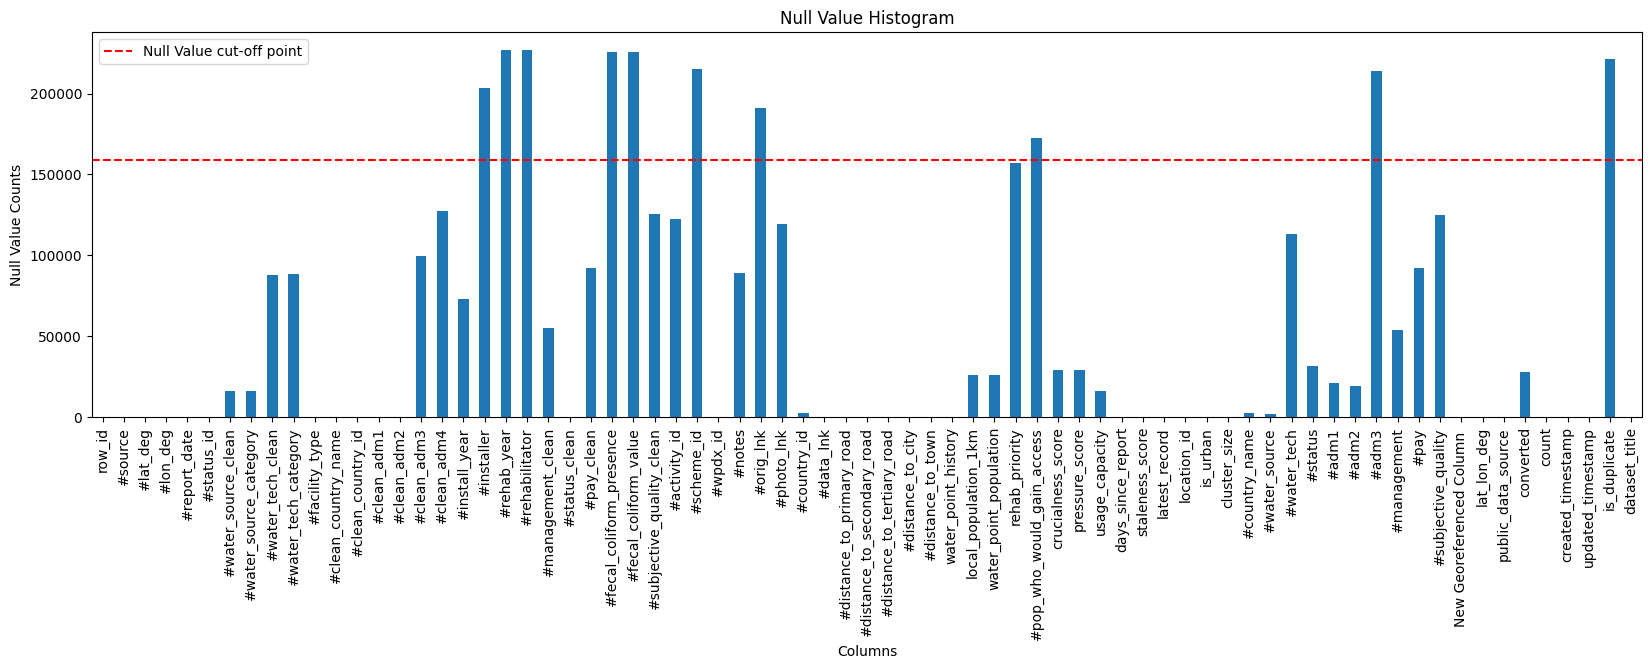

In [ ]:
# Count the number of null values in each column
null_counts = df_raw.isnull().sum()

# Create a histogram of null value counts
plt.figure(figsize=(20,5))
null_counts.plot(kind='bar')
plt.axhline(y=0.7*len(df_raw), color='r', linestyle='--', label='Null Value cut-off point')

# Set the plot title and axes labels
plt.title('Null Value Histogram')
plt.xlabel('Columns')
plt.ylabel('Null Value Counts')
plt.legend()

# Display the plot
plt.show()

## III. Cleaning (I)

In [ ]:
# Filter out duplicates
df_filtered = df_raw[df_raw['is_duplicate'] != True]
df_filtered.shape

(221246, 73)

In [ ]:
high_null = ['#installer', '#rehab_year', '#rehabilitator', '#fecal_coliform_presence', '#fecal_coliform_value', '#scheme_id', '#orig_lnk', 'rehab_priority', '#adm3', 'is_duplicate']
df_null_drop = df_filtered.drop(columns=high_null)

In [ ]:
# Drop High Null Columns

# Get list of high null columns (>70% nulls)
high_null = []
for i in range(len(df_filtered.isnull().sum())):
  if df_filtered.isnull().sum()[i] > 0.7*len(df_filtered):
    high_null.append(df_filtered.isnull().columns[i])
print(high_null)
# Drop high null columns
df_null_drop = df_filtered.drop(columns=high_null)

['#installer', '#rehab_year', '#rehabilitator', '#fecal_coliform_presence', '#fecal_coliform_value', '#scheme_id', '#orig_lnk', 'rehab_priority', '#pop_who_would_gain_access', '#adm3', 'is_duplicate']


Unfortunately the following columns that could have been useful needed to be dropped:


*   #rehab_year - when a waterpoint had its last major rehabilitation
*   #rehabilitator - name of entity/ies that did the most recent rehabilitation
*   #installer
*   #fecal_coliform_presence
*   #fecal_coliform_value
*   rehab_priority
*   #pop_who_would_gain_access

*Note, that rehabilitation priority comes from a wpdx tool




In [ ]:
check = df_null_drop[['#status_id', 'New Georeferenced Column ', 'cluster_size', 'converted', 'count', 'created_timestamp', 'lat_lon_deg','latest_record','location_id','public_data_source', 'row_id', 'water_point_history']]
# check.head()

**Other Data Notes:**

Variables that come from the rehabilitation priority tool:
- Potential population that would regain access if point was repaired (default)
  - too many nulls --> dropped
- Total population within 1km of water point
- Crucialness of water point (i.e., are there alternative water points nearby)
- Pressure on the water point (i.e., is the water point over or under-utilized)

New georeference column will be kept for the purposes of potential mapping later on.

In [ ]:
df_preclean = df_null_drop[['row_id', '#activity_id', '#clean_adm1', '#clean_adm2','#clean_adm3', '#clean_adm4', '#clean_country_id', \
 '#clean_country_name', 'location_id', '#distance_to_city', '#distance_to_primary_road','#distance_to_secondary_road', \
 '#distance_to_tertiary_road', '#distance_to_town', '#facility_type', '#install_year', '#lat_deg','#lon_deg', \
 '#management_clean','#pay_clean',  '#report_date', '#source', '#status_clean', '#status_id', \
 '#subjective_quality_clean', '#water_source_category', '#water_source_clean', '#water_tech_category',
 '#water_tech_clean', '#wpdx_id', 'crucialness_score', 'days_since_report', 'is_urban', 'local_population_1km', \
 'pressure_score',  'staleness_score', 'updated_timestamp', 'usage_capacity', 'water_point_population']]

**Notes about columns that are being dropped:**
*   In cases where there are two versions of the same column, only the clean version is kept
*   #notes is an open text column that has additional information not already part of the WPdx standard that is useful to the data provider. The type of information in this column is quite varied and only some may be useful. At this point, it has been decided that parsing this open text column is will not bring enough value for the amount of work that would be needed to gain useful information from it.
*   #status is an open text column about the status of the physical and mechanical condition of the water point. #status_clean incorporates information form this column and is used instead.

In [ ]:
# Columns that have been selected to be filtered out as they will not provide relevant information for the prediction task
# This does not include not clean columns
# This is only for reference
other_cols = ['#photo_lnk','#data_lnk', 'dataset_title', 'New Georeferenced Column ', 'cluster_size', \
              'converted', 'public_data_source', 'water_point_history', 'created_timestamp', \
             'lat_lon_deg', 'count', 'latest_record']

In [ ]:
df_preclean = df_null_drop

In [ ]:
print(df_preclean.columns)

Index(['row_id', '#source', '#lat_deg', '#lon_deg', '#report_date',
       '#status_id', '#water_source_clean', '#water_source_category',
       '#water_tech_clean', '#water_tech_category', '#facility_type',
       '#clean_country_name', '#clean_country_id', '#clean_adm1',
       '#clean_adm2', '#clean_adm3', '#clean_adm4', '#install_year',
       '#management_clean', '#status_clean', '#pay_clean',
       '#subjective_quality_clean', '#activity_id', '#wpdx_id', '#notes',
       '#photo_lnk', '#country_id', '#data_lnk', '#distance_to_primary_road',
       '#distance_to_secondary_road', '#distance_to_tertiary_road',
       '#distance_to_city', '#distance_to_town', 'water_point_history',
       'local_population_1km', 'water_point_population',
       '#pop_who_would_gain_access', 'crucialness_score', 'pressure_score',
       'usage_capacity', 'days_since_report', 'staleness_score',
       'latest_record', 'location_id', 'is_urban', 'cluster_size',
       '#country_name', '#water_source', 

## III. Target Variable Mapping

### EDA

In [ ]:
df_preclean['#status_id'] = df_preclean['#status_id'].astype('str')

# status_id
pd.DataFrame(df_preclean.groupby(['#status_id'])['row_id'].count())

,row_id
#status_id,
No,55943
Unknown,17299
Yes,148004


Look at **#status_id** for each country to inform mapping

In [ ]:
# Create df for each country
sierraleone_df = df_preclean.loc[df_preclean['#clean_country_name'] == "Sierra Leone"]
uganda_df = df_preclean.loc[df_preclean['#clean_country_name'] == "Uganda"]
nigeria_df = df_preclean.loc[df_preclean['#clean_country_name'] == "Nigeria"]

In [ ]:
sierraleone_df["#status_clean"].value_counts()

Non-Functional                14072
Functional, not in use        11813
Functional                     1367
Abandoned/Decommissioned         36
Non-Functional, dry season       15
Functional, needs repair          1
Name: #status_clean, dtype: int64

In [ ]:
uganda_df["#status_clean"].value_counts()

Functional                    66441
Non-Functional                28387
Functional, not in use         2311
Non-Functional, dry season      855
Abandoned/Decommissioned        473
Functional, needs repair        253
Name: #status_clean, dtype: int64

In [ ]:
nigeria_df["#status_clean"].value_counts()

Functional, not in use        52774
Non-Functional                39377
Non-Functional, dry season     2456
Abandoned/Decommissioned        355
Functional                      197
Functional, needs repair         63
Name: #status_clean, dtype: int64

Dry Season Notes:
- Sierra Leone: December - April
- Nigeria: November - March
- Uganda: June - August & December - February

### Mapping

In [ ]:
def wp_status(row):
  functional = ['Functional', 'Functional, needs repair', 'Functional, not in use']
  not_functional = ['Non-Functional', 'Abandoned/Decommissioned', 'Non-Functional, dry season']
  if row['#status_clean'] in functional:
    status_fin = 'functional'
  else:
    status_fin = 'not_functional'
  return status_fin

In [ ]:
df_preclean['status_fin'] = df_preclean.apply(wp_status, axis=1)

### Final Breakdown

In [ ]:
# status_fin
pd.DataFrame(df_preclean.groupby(['status_fin'])['row_id'].count())

,row_id
status_fin,
functional,135220
not_functional,86026


Class breakdown:


*   functional: 61.3%
*   not_functional: 38.6%





## V. Cleaning (II)

In [ ]:
df_clean = df_preclean
df_clean.shape

(221246, 64)

In [ ]:
df_clean['report_month'] = df_clean['#report_date'].apply(lambda x: int(x[0:2]))
df_clean['report_day'] = df_clean['#report_date'].apply(lambda x: int(x[3:5]))
df_clean['report_year'] = df_clean['#report_date'].apply(lambda x: int(x[6:10]))
df_clean['report_date'] = pd.to_datetime(df_clean['#report_date'])

**Dates Issues:**


*   some report dates in future; while their updated timestamps are in the past
*   specifically happening for Sierra Leone and Uganda in our dataset




In [ ]:
print('Earliest observation:', df_clean['report_date'].min())
print('Latest observation:', df_clean['report_date'].max())

Earliest observation: 2005-09-07 00:00:00
Latest observation: 2023-12-01 00:00:00


In [ ]:
def clean_install_year(df):
  '''
  Arg:
  Return: clean dataframe

  Does the following:
  - if install year is greater than year timestamp it should be Nan
  '''

  # Clean #install_year
  install_year = df['#install_year']
  if np.where(df[['#install_year', 'report_year']].notnull()):
    if df['#install_year'] > df['report_year']:
      install_year = np.NaN
  elif np.where(df['#install_year'].notnull()):
    install_year = df['#install_year']
  else:
    install_year = df['#install_year']

  return install_year

In [ ]:
def create_dry_col(df):
  if df['#status_clean'] == 'Non-Functional, dry season':
    val = 1
  else:
    val = 0
  return val

In [ ]:
def get_source_type(val):
  gov = ['Federal Ministry of Water Resources, Nigeria', 'Ministry of Water and Environment, Uganda', \
              'Ministry of Basic and Senior Secondary Education - Sierra Leone', 'Ministry of Water Resources, \
              Sierra Leone', 'Kenema Water Directorate',
              ]
  un = ['OCHA ROSEA','UNHCR','UNICEF', ]
  ngo = ['iMMAP', 'GOAL','World Vision','charity: water',  'CARE-Uganda-Otuke','World Vision WASH','IRC', \
         'Living Water International',  'Inter Aide', 'WaterAid UK', 'WaterAid', 'The Water Trust', \
         'The Water Trust Uganda',  'Water4','International Lifeline Fund', 'Drop in the Bucket',\
         'Evidence Action', 'Water For People', 'Ugandan Water Project','Stanford University and International Lifeline Fund', \
         'Aquaya','CRS RAIN Project', 'Water for People', ]
  other = ['C & D', 'YouthMappers', 'YouthMappers Gulu Chapter', 'TTC Mobile', 'Lifeline', 'GRID3']

  if val in gov:
    val = 'gov'
  elif val in un:
    val = 'un'
  elif val in ngo:
    val = 'ngo'
  else:
    val = 'other'
  return val

In [ ]:
df_clean['install_year'] = df_clean.apply(lambda s: clean_install_year(s), axis=1)
df_clean['not_func_dry_season'] = df_clean.apply(lambda s: create_dry_col(s), axis=1)
df_clean['source_type'] = df_clean['#source'].apply(lambda x: get_source_type(x))

In [ ]:
# Filter out rows after 2021
df_clean = df_clean[df_clean['report_year'] < 2022]
df_clean.shape

(214750, 71)

In [ ]:
df_clean = df_clean.drop(columns=['#source'])
df_clean.columns

Index(['row_id', '#lat_deg', '#lon_deg', '#report_date', '#status_id',
       '#water_source_clean', '#water_source_category', '#water_tech_clean',
       '#water_tech_category', '#facility_type', '#clean_country_name',
       '#clean_country_id', '#clean_adm1', '#clean_adm2', '#clean_adm3',
       '#clean_adm4', '#install_year', '#management_clean', '#status_clean',
       '#pay_clean', '#subjective_quality_clean', '#activity_id', '#wpdx_id',
       '#notes', '#photo_lnk', '#country_id', '#data_lnk',
       '#distance_to_primary_road', '#distance_to_secondary_road',
       '#distance_to_tertiary_road', '#distance_to_city', '#distance_to_town',
       'water_point_history', 'local_population_1km', 'water_point_population',
       '#pop_who_would_gain_access', 'crucialness_score', 'pressure_score',
       'usage_capacity', 'days_since_report', 'staleness_score',
       'latest_record', 'location_id', 'is_urban', 'cluster_size',
       '#country_name', '#water_source', '#water_tech', '#s

In [ ]:
df_clean = df_clean.drop(columns=['#install_year', '#report_date'])

In [ ]:
print('Earliest observation:', df_clean['report_date'].min())
print('Latest observation:', df_clean['report_date'].max())

Earliest observation: 2005-09-07 00:00:00
Latest observation: 2023-06-01 00:00:00


## VI. Change to 2021
This section will adjust the database to assume we are on December 31st, 2021. 

In [ ]:
df_2021 = df_clean
df_2021.head()

,row_id,#lat_deg,#lon_deg,#status_id,#water_source_clean,#water_source_category,#water_tech_clean,#water_tech_category,#facility_type,#clean_country_name,...,updated_timestamp,dataset_title,status_fin,report_month,report_day,report_year,report_date,install_year,not_func_dry_season,source_type
86,71934,7.670000,5.390000,Unknown,NaN,NaN,Public Tapstand,Public Tapstand,Improved,Nigeria,...,12/06/2021 09:12:57 PM,GRID3_Nigeria_2018-2020,not_functional,9,7,2018,2018-09-07,NaN,0,other
87,671815,6.776732,9.044447,Yes,Borehole/Tubewell,Well,Hand Pump,Hand Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,8,22,2015,2015-08-22,NaN,0,gov
88,396372,5.866844,7.373515,Yes,Borehole/Tubewell,Well,Motorized Pump,Motorized Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,2,26,2015,2015-02-26,NaN,0,gov
89,674097,6.910172,7.662312,Yes,Borehole/Tubewell,Well,Hand Pump,Hand Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,8,30,2015,2015-08-30,NaN,0,gov
90,604999,6.613382,3.298497,Yes,Borehole/Tubewell,Well,Motorized Pump,Motorized Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,5,28,2015,2015-05-28,2013.0,0,gov


In [ ]:
# to 2021
df_2021['report_month'] = 12
df_2021['report_day'] = 31
df_2021['report_year'] = 2021
df_2021.head()

,row_id,#lat_deg,#lon_deg,#status_id,#water_source_clean,#water_source_category,#water_tech_clean,#water_tech_category,#facility_type,#clean_country_name,...,updated_timestamp,dataset_title,status_fin,report_month,report_day,report_year,report_date,install_year,not_func_dry_season,source_type
86,71934,7.670000,5.390000,Unknown,NaN,NaN,Public Tapstand,Public Tapstand,Improved,Nigeria,...,12/06/2021 09:12:57 PM,GRID3_Nigeria_2018-2020,not_functional,12,31,2021,2018-09-07,NaN,0,other
87,671815,6.776732,9.044447,Yes,Borehole/Tubewell,Well,Hand Pump,Hand Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,12,31,2021,2015-08-22,NaN,0,gov
88,396372,5.866844,7.373515,Yes,Borehole/Tubewell,Well,Motorized Pump,Motorized Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,12,31,2021,2015-02-26,NaN,0,gov
89,674097,6.910172,7.662312,Yes,Borehole/Tubewell,Well,Hand Pump,Hand Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,12,31,2021,2015-08-30,NaN,0,gov
90,604999,6.613382,3.298497,Yes,Borehole/Tubewell,Well,Motorized Pump,Motorized Pump,Improved,Nigeria,...,06/30/2020 12:56:07 PM,Federal Ministry of Water Resources_Nigeria_2015,functional,12,31,2021,2015-05-28,2013.0,0,gov


# Secondary Data
[Global Data Lab](https://globaldatalab.org/)

[World Bank Development Indicators](https://databank.worldbank.org/source/world-development-indicators)

## I. Load

In [ ]:
# Load secondary data
# FILE_PATH = '/content/gdrive/My Drive/Capstone_Sum23/03_Data/01_wpdx/'
# FILE_PATH2 = '/content/gdrive/My Drive/Capstone_Sum23/03_Data/02_secondary/'

# Load wpdx data
# wpdx_df = pd.read_csv(FILE_PATH + 'clean_mapped_wpdx_sierraleone_nigeria_uganda.csv')
wpdx_df = df_2021

# Load secondary indicators - country level
country2_df = pd.read_csv('data/esg_data_country.csv')

# Load secondary indicators - region level
region2_df = pd.read_csv('data/gdl_data_region.csv')


## II. Initial EDA/Cleaning

General Information

In [ ]:
country2_df.info()
# Not too many nulls. Since it is not decided how the data will be split, nulls will not be replaced (not too many and tree models can handle it).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 17 columns):
 #   Column                                                                                          Non-Null Count  Dtype  
---  ------                                                                                          --------------  -----  
 0   Country                                                                                         54 non-null     object 
 1   Year                                                                                            54 non-null     int64  
 2   Access to electricity (% of population)                                                         48 non-null     float64
 3   Agricultural land (% of land area)                                                              48 non-null     float64
 4   Agriculture, forestry, and fishing, value added (% of GDP)                                      53 non-null     float64
 5   Annual freshwater

In [ ]:
region2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      1088 non-null   object 
 1   Region                       1088 non-null   object 
 2   Year                         1088 non-null   int64  
 3   log_gni_cap_1000usd_2011ppp  1088 non-null   float64
 4   hdi                          1088 non-null   float64
 5   perc_emp_women_agric         1066 non-null   object 
 6   perc_emp_men_agric           1066 non-null   object 
 7   avg_yrs_school_female        1088 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 68.1+ KB


In [ ]:
def float_convert(val):
  """
  Convert column values to float values.

  Args: row value

  Result: new float value
  """
  if val == '#DIV/0!':
    val = np.nan
  else:
    val = float(val)
  return val

Columns Present

In [ ]:
print(list(country2_df.columns))

['Country', 'Year', 'Access to electricity (% of population)', 'Agricultural land (% of land area)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Annual freshwater withdrawals, total (% of internal resources)', 'Cooling Degree Days', 'GDP growth (annual %)', 'Government Effectiveness: Estimate', 'Heat Index 35', 'Heating Degree Days', 'Land Surface Temperature', 'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources', 'Political Stability and Absence of Violence/Terrorism: Estimate', 'Regulatory Quality: Estimate', 'Rule of Law: Estimate', 'Voice and Accountability: Estimate']


In [ ]:
print(list(region2_df.columns))

['Country', 'Region', 'Year', 'log_gni_cap_1000usd_2011ppp', 'hdi', 'perc_emp_women_agric', 'perc_emp_men_agric', 'avg_yrs_school_female']


## III. Join Secondary Data with WPdx

In [ ]:
# Join wpdx and country indicators
wpdx_df['country2_key'] = wpdx_df['#clean_country_name'] + '_' + wpdx_df['report_year'].astype(str)
country2_df['country2_key'] = country2_df['Country'] + '_' + country2_df['Year'].astype(str)

print('Before join')
print('wpdx', wpdx_df.shape)
print('country2', country2_df.shape)

wpdx_df2 = pd.merge(wpdx_df, country2_df, on='country2_key', how='left')
wpdx_df2 = wpdx_df2.drop(columns = ['Country', 'Year'])
print()
print('After join')
print('wpdx2', wpdx_df2.shape)

Before join
wpdx (214750, 69)
country2 (54, 18)

After join
wpdx2 (214750, 84)


In [ ]:
def wpdx_region_key(df):
  if df['#clean_country_name'] == 'Sierra Leone':
    result = df['#clean_country_name'] + '_' + df['#clean_adm2'] + '_' + str(df['report_year'])
  else:
    result = df['#clean_country_name'] + '_' + df['#clean_adm1'] + '_' + str(df['report_year'])
  return result

In [ ]:
# Join wpdx_country with region indicators
wpdx_df2['region2_key'] = wpdx_df2.apply(lambda s: wpdx_region_key(s), axis=1)
region2_df['region2_key'] = region2_df['Country'] + '_' + region2_df['Region'] + '_' + region2_df['Year'].astype(str)

print('Before join')
print('wpdx2', wpdx_df2.shape)
print('region2', region2_df.shape)

wpdx_df3 = pd.merge(wpdx_df2, region2_df, on='region2_key', how='left')
wpdx_df3 = wpdx_df3.drop(columns = ['Country', 'Region', 'Year'])
print()
print('After join')
print('wpdx3', wpdx_df3.shape)

Before join
wpdx2 (214750, 85)
region2 (1088, 9)

After join
wpdx3 (214750, 90)


In [ ]:
df_joined = wpdx_df3
df_joined

,row_id,#lat_deg,#lon_deg,#status_id,#water_source_clean,#water_source_category,#water_tech_clean,#water_tech_category,#facility_type,#clean_country_name,...,Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Rule of Law: Estimate,Voice and Accountability: Estimate,region2_key,log_gni_cap_1000usd_2011ppp,hdi,perc_emp_women_agric,perc_emp_men_agric,avg_yrs_school_female
0,71934,7.670000,5.390000,Unknown,NaN,NaN,Public Tapstand,Public Tapstand,Improved,Nigeria,...,-1.779303,-0.932638,-0.855664,-0.636556,Nigeria_Ekiti_2021,8.483,0.614,0.01,42.1,8.7700
1,671815,6.776732,9.044447,Yes,Borehole/Tubewell,Well,Hand Pump,Hand Pump,Improved,Nigeria,...,-1.779303,-0.932638,-0.855664,-0.636556,Nigeria_Benue_2021,8.373,0.604,0.01,61.8,6.2180
2,396372,5.866844,7.373515,Yes,Borehole/Tubewell,Well,Motorized Pump,Motorized Pump,Improved,Nigeria,...,-1.779303,-0.932638,-0.855664,-0.636556,Nigeria_Imo_2021,8.965,0.647,0.01,10.9,9.7380
3,674097,6.910172,7.662312,Yes,Borehole/Tubewell,Well,Hand Pump,Hand Pump,Improved,Nigeria,...,-1.779303,-0.932638,-0.855664,-0.636556,Nigeria_Benue_2021,8.373,0.604,0.01,61.8,6.2180
4,604999,6.613382,3.298497,Yes,Borehole/Tubewell,Well,Motorized Pump,Motorized Pump,Improved,Nigeria,...,-1.779303,-0.932638,-0.855664,-0.636556,Nigeria_Lagos_2021,9.051,0.681,0.01,1.62,11.4300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214745,113355,1.055088,33.913393,Yes,Borehole/Tubewell,Well,NaN,NaN,Improved,Uganda,...,-0.859658,-0.476885,-0.352074,-0.821765,Uganda_Eastern_2021,7.584,0.525,#DIV/0!,#DIV/0!,4.6205
214746,168160,2.575640,34.647301,No,Borehole/Tubewell,Well,NaN,NaN,Improved,Uganda,...,-0.859658,-0.476885,-0.352074,-0.821765,Uganda_Northern_2021,7.351,0.478,#DIV/0!,#DIV/0!,3.3115
214747,109675,0.611798,33.304118,No,Borehole/Tubewell,Well,NaN,NaN,Improved,Uganda,...,-0.859658,-0.476885,-0.352074,-0.821765,Uganda_Eastern_2021,7.584,0.525,#DIV/0!,#DIV/0!,4.6205
214748,751757,1.056971,34.270544,Unknown,Protected Spring,Spring,NaN,NaN,Improved,Uganda,...,-0.859658,-0.476885,-0.352074,-0.821765,Uganda_Eastern_2021,7.584,0.525,#DIV/0!,#DIV/0!,4.6205


In [ ]:
# FILE_PATH3 = '/content/gdrive/My Drive/Capstone_Sum23/03_Data/'

df_joined.to_csv('data/clean_final_full_dataset_2021.csv') 

In [ ]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221092 entries, 0 to 221091
Data columns (total 66 columns):
 #   Column                                                                                          Non-Null Count   Dtype         
---  ------                                                                                          --------------   -----         
 0   row_id                                                                                          221092 non-null  int64         
 1   #activity_id                                                                                    98741 non-null   object        
 2   #clean_adm1                                                                                     221092 non-null  object        
 3   #clean_adm2                                                                                     221092 non-null  object        
 4   #clean_adm3                                                                           